
 # Extending Large Concept Models for KV Cache Compression

 Last month, Meta published a paper on [Large Concept Models (LCMs)](https://arxiv.org/pdf/2412.08821), introducing a novel approach to language modeling focused on next-concept embedding prediction rather than next-token prediction. The architecture has three transformer components: a token-to-concept encoder, the concept decoder (the LCM), and a concept-to-token decoder.

 The token-to-concept encoder maps token chunks into the concept embedding space, capturing high-level semantics. The concept decoder refines these embeddings and predicts the next concept embedding from context. The concept-to-token decoder projects the output embedding back into token space to generate text. By operating in the concept space, the model captures and manipulates semantic relationships more effectively than token-based models.

 The paper uses a pretrained encoder/decoder architecture called SONAR but requires carefully curated input sequences, as embedding quality declines with longer or more complex inputs. The authors assume input sentences average 10–20 tokens and cap sentence length at 200 characters to preserve semantic relationships.

 ## Methodology

 Seeing that LCM enables representing multiple tokens as a single concept, I propose leveraging it to compress the KV Cache across time. For simplicity, I have made the following modifications to Meta's approach:
 - Jointly train all encoders/decoders rather than using pretrained SONAR components. This also avoid its constraints of requiring careful selection for sequences.
 - Use fixed-size token blocks as concepts instead of dynamic sizing
 - Omit the diffusion-based LCM variants despite their superior performance

 ### Implementation Details

 The architecture consists of three components: a token-to-concept encoder with a mask (preventing attention to future concepts), a standard decoder operating in concept space, and a concept-to-token decoder that applies self-attention to input `x` followed by cross-attention with concept embedding `z`. I tested four reduction strategies for token-to-concept compression:
 - Sum
 - Max
 - Learned weighted sum
 - Attention based reduction

 All these implementation details can be see in [`train.py`](../train.py#L514) under the `forward_pass`. Further specifics on each component below:
 - [`encoder_block`](../train.py#L568)
 - [`concept_decoder_block`](../train.py#L664)
 - [`token_decoder_block`](../train.py#L776)


In [16]:
# %%
import importlib
import plot_helper
from experiments import LCM_EXPERIMENT_IDS

In [17]:
# %%
importlib.reload(plot_helper)
from plot_helper import *

In [18]:
# %%
metrics_data, config_data = get_metrics_data(LCM_EXPERIMENT_IDS)
# [(id, data["name"]) for (id, data) in metrics_data.items()]

## Results
When training a small 31m toy model on SlimPajama @ sequence length 1024, we are able to see that the [baseline](/configs/slim_v4-32_31m.yaml) model without any compression still outperforms all the LCM models throughout the training. This result holds even with block size 1, indicating that projecting tokens onto the concept embedding space causes a quality degradation. As expected, all reduction strategies pale in comparasion to applying attention not even registering within the top 10 experiments.

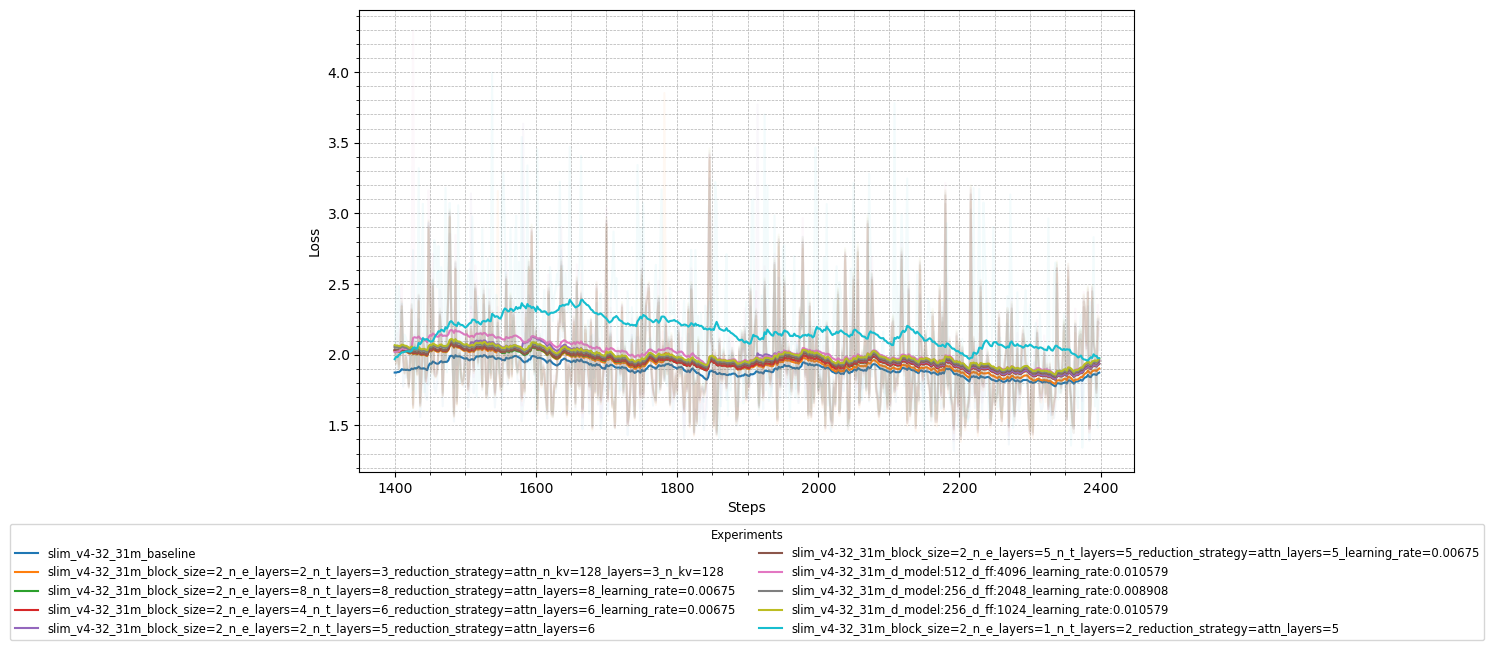

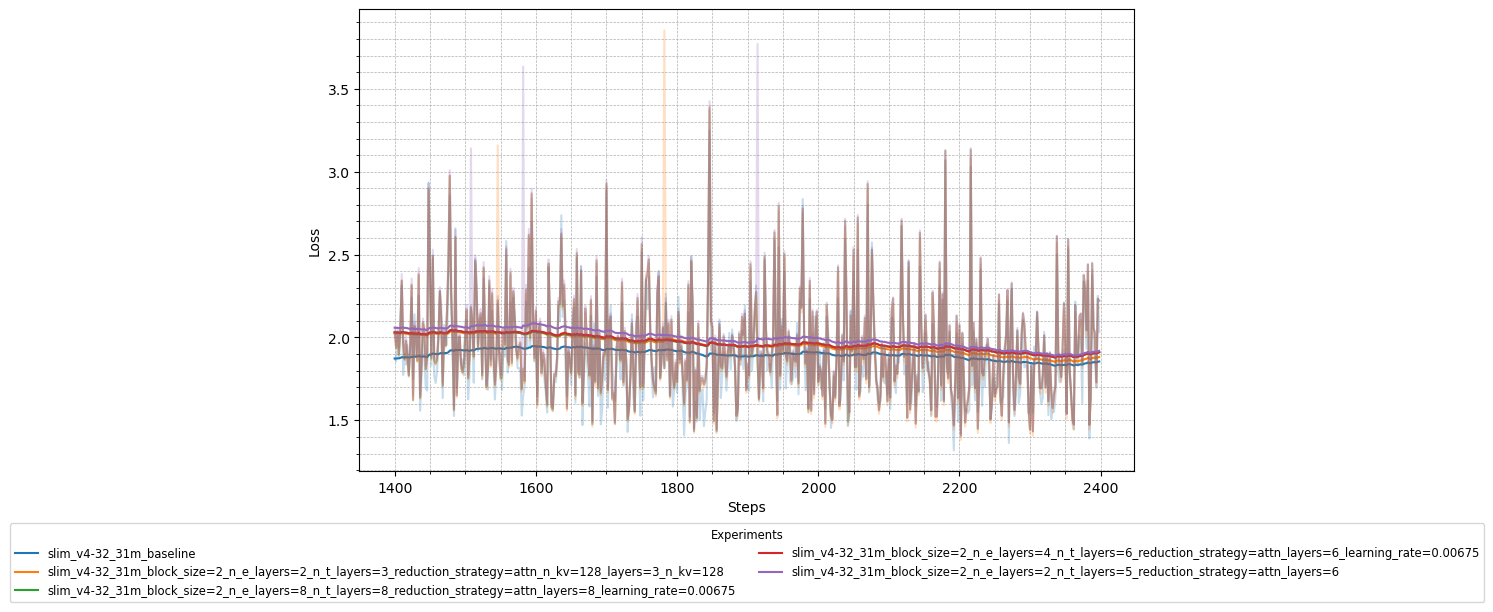

In [4]:
# %%

plot_loss_data(metrics_data, plot_last=500, ema_smoothing=0.97, top_k=10, opacity=0.05)
plot_loss_data(metrics_data, plot_last=500, ema_smoothing=0.99, top_k=5)

This results holds on the validation set (evaluated across 240 samples) even when giving our LCM 4-8x additional flops, either through:
- adding attention heads (32, 64, 128)
- modifying d_model (384, 512) and d_ff (4*d_model, 8_*d_model) 
- deepening the LCM's layers 

This significant quality, despite equivalent FLOPs already gives some pause and indicates that our concepts are losing some semantic quality. I suspect the following:
- Applying sequence packing will mix concept embeddings and the model has trouble attending to it since it loses semantic.
 makes our concepts more incoherent for the LCM and it wastes compute FLOPs attempting to make coherent concepts.
- Using a jointly-trained encoder/decoder instead of a pretrained one, forces the LCM to spend FLOPs learning how to form coherent concepts during training
- Not efficient use of data unlike base decoder transformer (?)

In [19]:
# %%
top_k_metrics_data = get_top_k_experiments(metrics_data, k=10, ema_smoothing=0.97)
get_eval_metrics_table(metrics_data, config_data)

,Name,Eval Loss,Block_Size,Concept_Decoder_Layers,Encoder_Layers,Token_Decoder_Layers,Reduction_Strategy,Attention_Heads,Learning_Rate,d_model,d_ff
0,slim_v4-32_31m_baseline,1.849695,-,8,-,-,-,16,0.013500,256,1024
1,slim_v4-32_31m_block_size...,1.874595,2,3,2,3,attn,128,0.013500,256,1024
2,slim_v4-32_31m_block_size...,1.908515,2,8,8,8,attn,16,0.006750,256,1024
3,slim_v4-32_31m_block_size...,1.908937,2,6,4,6,attn,16,0.006750,256,1024
4,slim_v4-32_31m_block_size...,1.911174,2,6,2,5,attn,16,0.013500,256,1024
5,slim_v4-32_31m_block_size...,1.927374,2,5,5,5,attn,16,0.006750,256,1024
6,slim_v4-32_31m_d_model:51...,1.934949,2,3,2,3,attn,16,0.010579,512,4096
7,slim_v4-32_31m_d_model:25...,1.935532,2,3,2,3,attn,16,0.008908,256,2048
8,slim_v4-32_31m_block_size...,1.936809,2,3,3,3,attn,16,0.013500,256,1024
9,slim_v4-32_31m_d_model:25...,1.945458,2,3,2,3,attn,16,0.010579,256,1024


## Conclusions
Despite its compressive qualities, applying the base LCM architecture has significant performance degradation. As follow ups I'd reccomend the following:

- Disabling sequence packing
- Loading and using a pretrained encoder/decoder eg. SONAR, T5
- Investigate applying a jointly trained encoder/decoder with their diffusion based LCM architecture

I suspect that LCM's use of data isn't as efficient and would pursue other strategies to reduce the KV Cache's footprint.